In [1]:
# Deniz Gökduman
# 501191674
#########################
from typing import Optional, Callable, Union
from itertools import combinations as C
from collections import defaultdict

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
##########################

## Part A: Simulate exponential and free-scale networks

In [2]:
class ErdosRenyiNetwork:
    def __init__(self):
        """
        A network class used to generate an undirected adjacency matrix using the Erdős-Rényi model
        """    
    def __call__(self, n:int, p:float, wFunc:Union[Callable,int,float]=1, seed:Optional[int]=None, **args) -> np.ndarray:
        """
        To generate an adjacency matrix
        
        ER = ErdosRenyiNetwork()
        ER(n<int>, p<float>)
        
        this model specifies the number of node, n, and each pair of node has p probability of an edge existing between the two

        Parameters
        ----------
        n     : int
            The number of nodes in the final graph            
        p     : int
            The number of edges in the final graph            
        wFunc : Callable | int | float
            if wFunc is an callable, weights of edges are assigned with function
            if wFunc is an integer or float, weights of edges are assigned with this constant value (default 1)            
        seed  : int, optional
            Initialize the random number generator with given seed (default None)            
        args  : dict, optional
            Arguments to be used in the callable wFunc (default None)

        Raises
        ------
        ValueError
            If p is not float type            
        AssertionError
            If p probability is not between [0,1]
            
        Returns
        -------
        np.ndarray
            Adjacency array representing an undirected graph without loops
        """
        if isinstance(p,float):                                                     # Checking if the given probability threshold is float type
            assert 0 <= p <= 1, 'Probability must be between [0,1]'                 # Checking if the given probability threshold is valid (i.e., between 0% and 100%)
            np.random.seed(seed)                                                    # Fixing random state for reproducibility
            mask = np.random.rand(n,n) < p                                          # Creating a mask which is True when the generated random number is less than the threshold

        else: raise TypeError('p must be float type')                               # Raising TypeError when the probability threshold is not float type

        if isinstance(wFunc,(float,int)): wArr = np.full((n,n),wFunc)               # Creating a constant weight array full of wFunc if the given wFunc is either integer or float type
        else                            : wArr = wFunc(size=(n,n),**args)           # Creating a randomly generated weight array with the the given callable wFunc

        adj = np.where(mask,wArr,0)                                                 # Creating an adjacency array, where adj_ij is 0 (mask_ij is False) or weight_ij (mask_ij is True)
        np.fill_diagonal(adj, 0)                                                    # To remove self-loops, diagonal values are reassigned as 0
        adj = np.triu(adj) + np.triu(adj).T                                         # Lower-triangle of the array is overwritten by the upper-triangle to make it undirected
        return adj


In [3]:
class BarabasiAlbertNetwork:
    def __init__(self):
        """
        A network class used to generate an undirected adjacency matrix using the Barabási-Albert model
        """    
    def __call__(self, m0:int, m:int, M:int, wFunc:Union[Callable,int,float]=1, seed:Optional[int]=None, **args) -> np.ndarray:
        """
        To generate an adjacency matrix
        
        BA = BarabasiAlbertNetwork()
        BA(m0<int>, m<int>, M<int>)
        
        this model specifies the number of node, M, with m0 starting nodes and m edges created by each new node
        
        Parameters
        ----------
        m0    : int
            Initial number of nodes, where m0 >= m            
        m     : int
            The number of edges added to the graph with each new node, where m > 0            
        M     : int
            The number of edges in the final graph            
        wFunc : Callable | int | float
            if wFunc is an callable, weights of edges are assigned with function
            if wFunc is an integer or float, weights of edges are assigned with this constant value (default 1)            
        seed  : int, optional
            Initialize the random number generator with given seed (default None)            
        args  : dict, optional
            Arguments to be used in the callable wFunc (default None)

        Raises
        ------
        AssertionError
            If the condition m0 >= m > 0 is not met
            
        Returns
        -------
        np.ndarray
            Adjacency array representing an undirected graph without loops
        """
        assert m0 >= m > 0, 'The condition m0 >= m > 0 is not met'                  # Checking if the given m0 and m values are valid (i.e., m0 >= m > 0)
        np.random.seed(seed)                                                        # Fixing random state for reproducibility
        nodes = defaultdict(list, {i:[i-1,i+1] for i in range(m0)})                 # The network begins with an initial connected network of m0 nodes
        nodes[0].remove(-1); nodes[m0-1].remove(m0)                                 # Some connections are manually removed since there isn't neither node(-1) nor node(m0) yet        
        
        for i in range(m0,M):                                                       # New nodes are added to the network in each epoch until the graph has M nodes
            ki  = np.array([sum(vals) for vals in nodes.values()]) + 1E-8           # Degree of each node in the graph, added 1E-8 in order to avoid 0 probability
            kij = ki.sum()                                                          # The sum is made over all pre-existing nodes
            pi  = ki / kij                                                          # The probability of that the new node is connected to node i can be calculated as ki / kij
            j   = np.random.choice(list(nodes.keys()), size=m, replace=False, p=pi) # m nodes are selected according to their corresponding pi probabilities
            
            nodes[i].extend(j.tolist())                                             # edges are created between the newly added node and the selected j nodes
            for _ in j: nodes[_].append(i)                                          # Since it is undirected graph, the connections are created from the other node as well

        mask = np.full((M,M), False, dtype=bool)                                    # A mask array (M,M) created to be used for assigning edge weights
        for ni, njj in nodes.items(): mask[ni,njj] = mask[njj,ni] = True            # The mask array values are assigned as True (nodes are connected) or False (nodes are not connected)
        
        if isinstance(wFunc,(float,int)): wArr = np.full((M,M),wFunc)               # Creating a constant weight array full of wFunc if the given wFunc is either integer or float type
        else                            : wArr = wFunc(size=(M,M),**args)           # Creating a randomly generated weight array with the the given callable wFunc

        adj = np.where(mask,wArr,0)                                                 # Creating an adjacency array, where adj_ij is 0 (mask_ij is False) or weight_ij (mask_ij is True)
        return adj

In [12]:
def Adj2Graph(adj:np.ndarray,only_graph:bool=False) -> Union[nx.Graph,dict]:
    nrow, _ = adj.shape
    nodes   = [f'n{num}' for num in range(nrow)]         # The graph is assumed to have nrow nodes
    edges   = []                                         # A list for storing edges
    weights = []                                         # A list for storing edge weights
    
    ij      = C(range(nrow), 2)                          # Since the graph is assumed as undirected and without self-loop
    for i, j in ij:                                      # only values in the upper-triangle are used
        if adj[i,j] != 0:                                # A non-zero value in adjacency array shows that node_i and node_j are connected
            edges.append([nodes[i], nodes[j], adj[i,j]])
            weights.append(adj[i,j])
    
    G = nx.Graph()
    G.add_nodes_from(nodes)                              # Stored nodes are added to the undirected graph
    G.add_weighted_edges_from(edges)                     # Stored edges are added to the undirected graph with their weights
    
    w33, w66 = np.percentile(weights, [33, 66])          # An additional step was to divide weights into three parts and then
    eL,eM,eS = [],[],[]                                  # name them as small, medium, and large to emphasize their weight
    
    for (u,v,d) in G.edges(data=True):
        if   d['weight'] >= w66: eL.append([u,v])
        elif d['weight'] >= w33: eM.append([u,v])
        else                   : eS.append([u,v])
        
    results = {"graph":G,
               "edges_large":eL,
               "edges_medium":eM,
               "edges_small":eS}                         # nx.Graph and divided edges are returned separately for further steps
    
    if only_graph: return G                              # An option is provided for those only wanting nx.Graph
    else         : return results
    
def plot_single(adj, title, figsize=(10,10)):
    result = Adj2Graph(adj)
    nopt   = {"node_color":"red","node_size":30}
    eoptL  = {"edge_color":"black","width": 1.00,"alpha":0.80}
    eoptM  = {"edge_color":"gray" ,"width": 0.75,"alpha":0.50}
    eoptS  = {"edge_color":"gray" ,"width": 0.25,"alpha":0.20}
       
    fig  = plt.figure(figsize=figsize)
    grid = fig.add_gridspec(3, 2)
    
    ax0  = fig.add_subplot(grid[0:2,:])
    pos  = nx.circular_layout(result["graph"])  
    nx.draw_networkx_nodes(result["graph"], pos, ax=ax0, **nopt)
    nx.draw_networkx_edges(result["graph"], pos, edgelist=result["edges_large" ], ax=ax0, **eoptL)
    nx.draw_networkx_edges(result["graph"], pos, edgelist=result["edges_medium"], ax=ax0, **eoptM)
    nx.draw_networkx_edges(result["graph"], pos, edgelist=result["edges_small" ], ax=ax0, **eoptS)
    ax0.set_title(title,fontweight="bold")
    ax0.set_axis_off()
    
    degs = [d for (n, d) in result["graph"].degree()]    
    ax1  = fig.add_subplot(grid[2,0])
    ax1.bar(*np.unique(degs, return_counts=True))
    ax1.set_xlabel("Degree")
    ax1.set_ylabel("# of Nodes") 
    
    ax2  = fig.add_subplot(grid[2,1])
    im   = ax2.imshow(adj,cmap="magma")
    plt.colorbar(im, ax=ax2)
    ax2.set_title("Adjacency Matrix")
    ax2.set_axis_off()   
    
    fig.tight_layout()
    plt.show()
    
def deg_centrality(adj):
    nrows, _ = adj.shape
    colVec   = np.ones((nrows,1))
    degrees  = adj @ colVec
    return degrees

def eig_centrality(adj):
    nrows, _ = er.shape
    colVec0  = np.random.rand(nrows,1)
    #https://en.wikipedia.org/wiki/Power_iteration

In [37]:
arr = np.array([[0,1,1,1,0,0,0,0],
                [1,0,1,0,0,0,0,0],
                [1,1,0,1,0,0,0,0],
                [1,0,1,0,1,0,0,0],
                [0,0,0,1,0,1,0,0],
                [0,0,0,0,1,0,1,1],
                [0,0,0,0,0,1,0,1],
                [0,0,0,0,0,1,1,0]])

nrows, _ = arr.shape
colVec   = np.random.rand(nrows,1)
delta    = -1

for i in range(100):
    norm_0 = np.linalg.norm(colVec)
    prod   = arr @ colVec
    norm_i = np.linalg.norm(prod)
    delta  = abs(norm_i - norm_0)
    colVec = prod / norm_i
    print(delta)

2.8035720156431188
1.5548246370802246
1.607082755690953
1.6301649682601544
1.6440701736897845
1.6531853589020469
1.659235753532191
1.6632408801048482
1.6658806405934383
1.667614595013613
1.6687509400428482
1.6694945429931525
1.6699806974604905
1.6702983618141123
1.6705058648579163
1.6706413853376083
1.6707298863075355
1.6707876794603327
1.670825419545943
1.6708500648622135
1.6708661592402305
1.6708766697415514
1.6708835338170294
1.6708880166172886
1.6708909443033053
1.6708928563845964
1.6708941051876391
1.6708949208048258
1.6708954535049556
1.6708958014274833
1.6708960286676051
1.6708961770866742
1.6708962740251518
1.6708963373397947
1.6708963786933944
1.670896405703322
1.6708964233447738
1.6708964348672506
1.6708964423931407
1.6708964473086696
1.6708964505192467
1.670896452616235
1.670896453985884
1.670896454880471
1.6708964554647716
1.6708964558464081
1.6708964560956745
1.670896456258483
1.6708964563648219
1.670896456434277
1.670896456479642
1.6708964565092717
1.670896456528625
1.670

In [35]:
delta

1.6527584275257747

In [13]:

def power_iteration(A, num_simulations: int):
    # Ideally choose a random vector
    # To decrease the chance that our vector
    # Is orthogonal to the eigenvector
    b_k = np.random.rand(A.shape[1])

    for _ in range(num_simulations):
        # calculate the matrix-by-vector product Ab
        b_k1 = np.dot(A, b_k)

        # calculate the norm
        b_k1_norm = np.linalg.norm(b_k1)

        # re normalize the vector
        b_k = b_k1 / b_k1_norm

    return b_k

2772

#### Part A.1. Briefly explain how the weighted Erdos-Renyi generative model works.

First, a number of nodes are created without any connection, then a random number between [0-1] is independetly created for each possible pairs of nodes. To decide if a pair of nodes is connected a p value is used as a possibility threshold. If the random number created for the pair is less than p, the pair is assumed to be connected 

#### Part A.2. What are the key properties of weighted Erdos-Renyi (ER) graphs?

Erdos-Renyi model can be characterized by two parameters, the number of nodes in the graph ($N$), and the probability threshold ($p$) that is used for deciding if a node pair is connected. By construction, the number of connections in the graph is binomially distributed, and can be formulized as

$$P(number\:of\:edges = E)= Binom(m,E) p^E (1-p)^{m-E}$$

The expected number of node degree can be shown as

$$\left\langle k \right\rangle =(N-1)p$$

Therefore, a Erdos-Renyi model with $\left \langle k \right \rangle$ can be achieved for large networks by using the following equation

$$p=\frac{\left\langle k \right\rangle}{N-1}$$

#### Part A.3. Briefly explain how weighted scale-free (SF) algorithm works.

First, $m_0$ interconnected nodes are created and then new nodes are added iteratively. When the iterations stops ($M$) and how many connections this newly added node will have ($m$) are predefined. The probability of an existing node to be connected this new node ($p_i$) is proportional to its current nodal degree 

$$p_i=\frac{k_i}{\sum _j k_i}$$

where $k_i$ is the degree of node $i$ and the sum is made over all pre-existing nodes $j$

#### Part A.4. What are the key properties of weighted SF graphs?

A SF graph is expected to have hub nodes since high-degree nodes have higher chance to connet new nodes. Iterations can be expected to grow the graph in a manner of "rich get richer". A graph created by this model has a connection density of $\frac{2m}{M-1}$ and a scale-free node degree distribution that follows a power law of the form $P(degree=k)\sim k^{-\gamma}$

#### Part A.5. Visualize two random graphs you simulated (ER and SF).



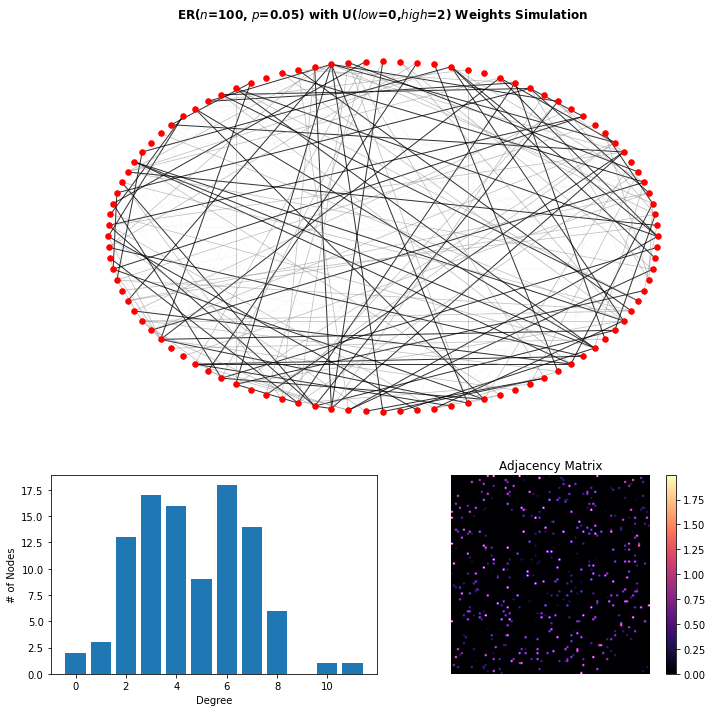

In [6]:
ER = ErdosRenyiNetwork()
er = ER(100,.05,np.random.uniform,low=0,high=2)
plot_single(er, 'ER($n$=100, $p$=0.05) with U($low$=0,$high$=2) Weights Simulation', (10,10))

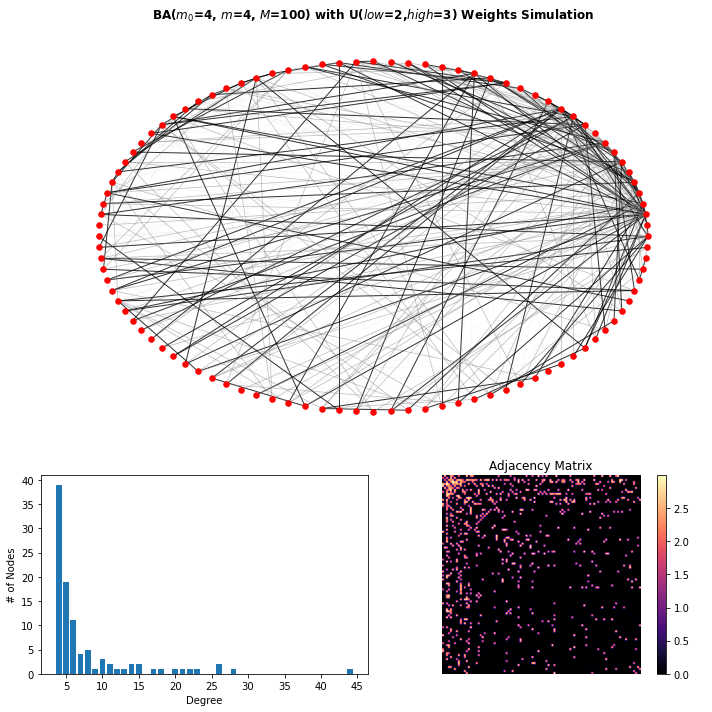

In [6]:
BA = BarabasiAlbertNetwork()
ba = BA(4,4,100,np.random.uniform,low=2,high=3)
plot_single(ba, 'BA($m_0$=4, $m$=4, $M$=100) with U($low$=2,$high$=3) Weights Simulation', (10,10))

#### Part A.6. Plot the overlaid distributions of the node strength centrality for all 30 ER graphs (transparent blue color) and the 30 SF graphs (transparent red color). What do you notice? Interpret your observation.



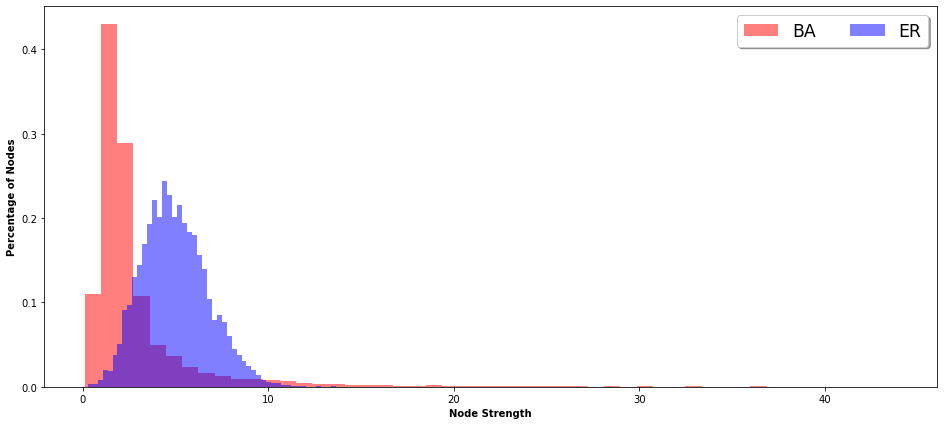

In [7]:
ba_param = dict(bins=50, alpha=0.5, color='r', label='BA', density=True)
er_param = dict(bins=50, alpha=0.5, color='b', label='ER', density=True)
lg_param = dict(loc="upper right",ncol=2, fontsize="xx-large", shadow=True)

ba_adjs  = [BA(5,3,200,np.random.uniform,low=0,high=1) for _ in range(30)]
er_adjs  = [ER(200,.05,np.random.uniform,low=0,high=1) for _ in range(30)]

ba_str   = np.hstack([adj.sum(axis=1) for adj in ba_adjs])
er_str   = np.hstack([adj.sum(axis=1) for adj in er_adjs])

fig, ax  = plt.subplots(1,1,figsize=(16,7))
ax.set_xlabel("Node Strength", fontweight="bold")
ax.set_ylabel("Percentage of Nodes", fontweight="bold")

ax.hist(ba_str, **ba_param)
ax.hist(er_str, **er_param)
        
plt.legend(**lg_param)
plt.show()

#### Part A.7. Plot the overlaid distributions of the eigenvector centrality for all 30 ER graphs (transparent blue color) and the 30 SF graphs (transparent red color). What do you notice? Interpret your observation.

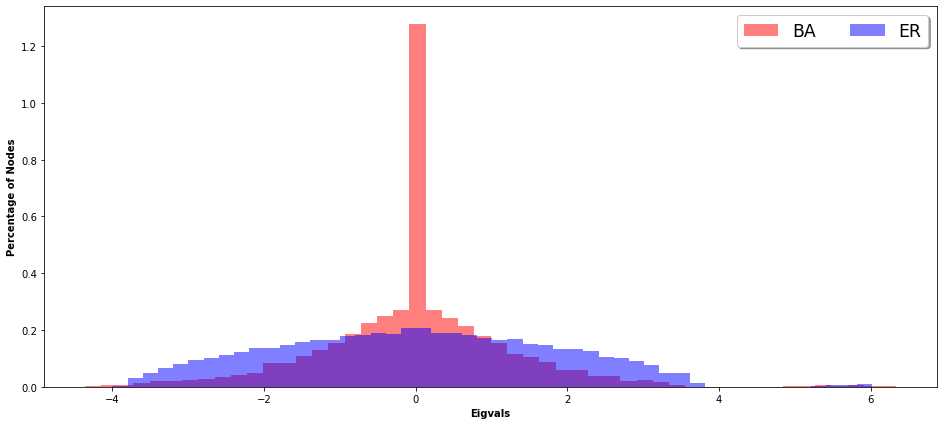

In [10]:
ba_param = dict(bins=50, alpha=0.5, color='r', label='BA', density=True)
er_param = dict(bins=50, alpha=0.5, color='b', label='ER', density=True)
lg_param = dict(loc="upper right",ncol=2, fontsize="xx-large", shadow=True)

ba_adjs  = [BA(5,3,200,np.random.uniform,low=0,high=1) for _ in range(30)]
er_adjs  = [ER(200,.05,np.random.uniform,low=0,high=1) for _ in range(30)]

ba_eig   = np.hstack([np.linalg.eigvals(adj) for adj in ba_adjs])
er_eig   = np.hstack([np.linalg.eigvals(adj) for adj in er_adjs])

fig, ax  = plt.subplots(1,1,figsize=(16,7))
ax.set_xlabel("Eigvals", fontweight="bold")
ax.set_ylabel("Percentage of Nodes", fontweight="bold")

ax.hist(ba_eig, **ba_param)
ax.hist(er_eig, **er_param)
        
plt.legend(**lg_param)
plt.show()

## Part B: Analyzing Erdos-Renyi and Scale-Free graphs in both random error and target attack scenarios

In [12]:
#Implement PART B:
def power_iteration(A, num_simulations:int=50):
    # Ideally choose a random vector
    # To decrease the chance that our vector
    # Is orthogonal to the eigenvector
    b_k = np.random.rand(A.shape[1])

    for _ in range(num_simulations):
        # calculate the matrix-by-vector product Ab
        b_k1 = np.dot(A, b_k)

        # calculate the norm
        b_k1_norm = np.linalg.norm(b_k1)

        # re normalize the vector
        b_k = b_k1 / b_k1_norm

    return b_k

arr = power_iteration(np.array([[0,0,1],[1,0,0],[1,1,0]]))

In [13]:
(arr-arr.min())/(arr.max()-arr.min())

array([0.43015971, 0.        , 1.        ])

Add your written answers here